In [16]:
!pip3 install polygon-api-client pandas requests matplotlib

In [17]:
import pandas as pd
import requests

# Initialize Polygon API
api_key = "api-key"
client = RESTClient(api_key)

# Function to fetch historical data
def get_historical_data(ticker, timespan='minute', from_date='2023-01-01', to_date='2023-09-01', limit=50000):
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/{timespan}/{from_date}/{to_date}?adjusted=true&sort=asc&limit={limit}&apiKey={api_key}"
    
    response = requests.get(url)
    data = response.json()

    # Create a DataFrame from the Polygon data
    df = pd.DataFrame(data['results'])
    df['timestamp'] = pd.to_datetime(df['t'], unit='ms')
    df.set_index('timestamp', inplace=True)

    # Rename columns to match what we need
    df.rename(columns={'o': 'Open', 'h': 'High', 'l': 'Low', 'c': 'Close', 'v': 'Volume'}, inplace=True)

    return df

"""
# Example usage
ticker = "C:EURUSD"
start_date = "2023-01-01"
end_date = "2024-01-01"
historical_data = get_historical_data(ticker, 'minute', start_date, end_date)
"""

'\n# Example usage\nticker = "C:EURUSD"\nstart_date = "2023-01-01"\nend_date = "2024-01-01"\nhistorical_data = get_historical_data(ticker, \'minute\', start_date, end_date)\n'

In [18]:
# Calculate Bollinger Bands
def calculate_bollinger_bands(df, window=20, num_std=2):
    df['SMA'] = df['Close'].rolling(window).mean()
    df['STD'] = df['Close'].rolling(window).std()
    df['Upper Band'] = df['SMA'] + (df['STD'] * num_std)
    df['Lower Band'] = df['SMA'] - (df['STD'] * num_std)
    return df

In [19]:
def generate_signals(df, window=20, std_dev=2):
    df['MA20'] = df['Close'].rolling(window=window).mean()
    df['BB_upper'] = df['MA20'] + std_dev * df['Close'].rolling(window=window).std()
    df['BB_lower'] = df['MA20'] - std_dev * df['Close'].rolling(window=window).std()

    df['Buy Signal'] = (df['Close'] < df['BB_lower'])
    df['Sell Signal'] = (df['Close'] > df['BB_upper'])

    return df

/var/folders/b_/rf0bpmls55x3h72ntzc7330m0000gn/T/ipykernel_19774/2202853321.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df['Buy Signal'][i] and position == 0:
/var/folders/b_/rf0bpmls55x3h72ntzc7330m0000gn/T/ipykernel_19774/2202853321.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif df['Sell Signal'][i] and position > 0:
/var/folders/b_/rf0bpmls55x3h72ntzc7330m0000gn/T/ipykernel_19774/2202853321.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a valu

Win Rate: 100.00%
Average Trades per Hour: 0.46
Final Balance: 10675.0038495717
                    Time    Symbol  Type    Price Risk      Profit  \
0    2023-03-01 00:43:00  C:EURUSD   Buy  1.05660  N/A    0.000000   
1    2023-03-01 01:07:00  C:EURUSD  Sell  1.05698  N/A    3.596441   
2    2023-03-01 02:32:00  C:EURUSD   Buy  1.05821  N/A    0.000000   
3    2023-03-01 03:06:00  C:EURUSD  Sell  1.05854  N/A    6.716037   
4    2023-03-01 03:48:00  C:EURUSD   Buy  1.05930  N/A    0.000000   
...                  ...       ...   ...      ...  ...         ...   
1065 2023-04-18 03:01:00  C:EURUSD  Sell  1.09358  N/A  665.541176   
1066 2023-04-18 03:43:00  C:EURUSD   Buy  1.09340  N/A    0.000000   
1067 2023-04-18 05:00:00  C:EURUSD  Sell  1.09385  N/A  669.930689   
1068 2023-04-18 06:07:00  C:EURUSD   Buy  1.09367  N/A    0.000000   
1069 2023-04-18 06:31:00  C:EURUSD  Sell  1.09419  N/A  675.003850   

           balance  
0              NaN  
1     10003.596441  
2              N

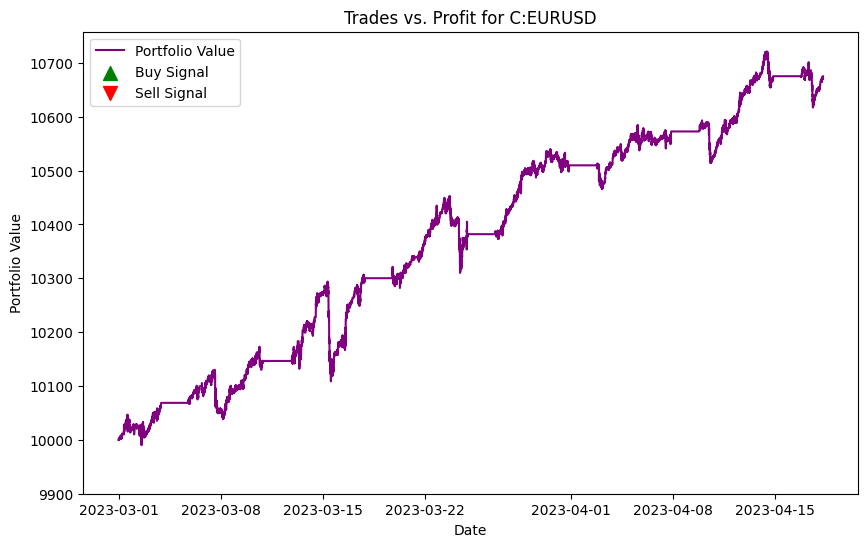

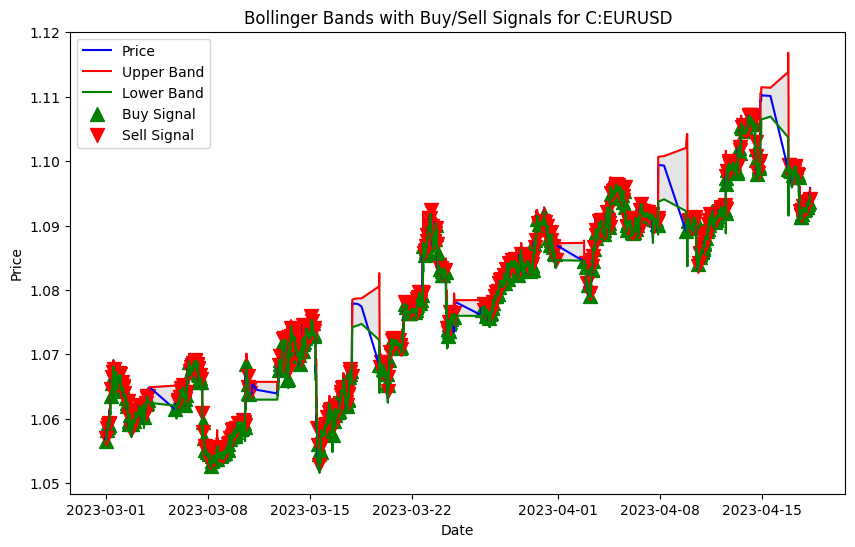

In [20]:
import matplotlib.pyplot as plt

def backtest_with_analysis(df, initial_balance=10000):
    balance = initial_balance
    position = 0  # Amount of shares held
    balance_history = [initial_balance]
    trades = []

    for i in range(1, len(df)):
        trade_data = {}

        if df['Buy Signal'][i] and position == 0:
            # Execute Buy Trade
            position = balance / df['Close'][i]
            trade_data['Time'] = df.index[i]
            trade_data['Symbol'] = ticker
            trade_data['Type'] = 'Buy'
            trade_data['Price'] = df['Close'][i]
            trade_data['Risk'] = 'N/A'
            trade_data['Profit'] = 'N/A'
            trades.append(trade_data)
            balance = 0

        elif df['Sell Signal'][i] and position > 0:
            # Execute Sell Trade
            balance = position * df['Close'][i]
            trade_data['balance'] = balance
            trade_data['Time'] = df.index[i]
            trade_data['Symbol'] = ticker
            trade_data['Type'] = 'Sell'
            trade_data['Price'] = df['Close'][i]
            trade_data['Risk'] = 'N/A'
            trade_data['Profit'] = balance - initial_balance
            trades.append(trade_data)
            position = 0

        # Update balance history for each minute
        balance_history.append(balance + position * df['Close'][i])

    df['Portfolio Value'] = balance_history[:len(df)]
    trade_df = pd.DataFrame(trades)

    return df, trade_df

def calculate_performance_metrics(trade_df, df):
    # Convert 'Profit' column to numeric, setting errors='coerce' to turn non-numeric values into NaN
    trade_df['Profit'] = pd.to_numeric(trade_df['Profit'], errors='coerce').fillna(0)

    # Calculate number of winning trades
    wins = trade_df[trade_df['Profit'] > 0].shape[0]
    total_trades = trade_df.shape[0] // 2  # Each round includes buy and sell

    win_rate = wins / total_trades if total_trades > 0 else 0
    time_period_hours = (df.index[-1] - df.index[0]).total_seconds() / 3600
    avg_trades_per_hour = total_trades / time_period_hours if time_period_hours > 0 else 0

    print(f"Win Rate: {win_rate:.2%}")
    print(f"Average Trades per Hour: {avg_trades_per_hour:.2f}")
    print(f"Final Balance: {trade_df['balance'].iloc[-1]}")

    return win_rate, avg_trades_per_hour

def plot_trades_vs_profit(df, trade_df):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot Portfolio Value
    ax.plot(df.index, df['Portfolio Value'], label='Portfolio Value', color='purple')
    ax.set_ylim(10000 - sum(trade_df['Profit'] < 0) - 100)

    # Plot Buy and Sell trades
    buy_trades = trade_df[trade_df['Type'] == 'Buy']
    sell_trades = trade_df[trade_df['Type'] == 'Sell']

    ax.scatter(buy_trades['Time'], buy_trades['Price'], marker='^', color='green', label='Buy Signal', alpha=1, s=100)
    ax.scatter(sell_trades['Time'], sell_trades['Price'], marker='v', color='red', label='Sell Signal', alpha=1, s=100)

    ax.set_ylabel('Portfolio Value')
    ax.set_xlabel('Date')
    ax.legend(loc='upper left')

    plt.title(f'Trades vs. Profit for {ticker}')
    plt.show()

def plot_bollinger_bands_with_trades(df, trade_df):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot stock price and Bollinger Bands
    ax.plot(df.index, df['Close'], label='Price', color='blue')
    ax.plot(df.index, df['Upper Band'], label='Upper Band', color='red')
    ax.plot(df.index, df['Lower Band'], label='Lower Band', color='green')
    ax.fill_between(df.index, df['Lower Band'], df['Upper Band'], color='gray', alpha=0.2)

    # Plot Buy and Sell trades
    buy_trades = trade_df[trade_df['Type'] == 'Buy']
    sell_trades = trade_df[trade_df['Type'] == 'Sell']

    ax.scatter(buy_trades['Time'], buy_trades['Price'], marker='^', color='green', label='Buy Signal', alpha=1, s=100)
    ax.scatter(sell_trades['Time'], sell_trades['Price'], marker='v', color='red', label='Sell Signal', alpha=1, s=100)

    ax.set_ylabel('Price')
    ax.set_xlabel('Date')
    ax.legend(loc='upper left')

    plt.title(f'Bollinger Bands with Buy/Sell Signals for {ticker}')
    plt.show()

# Full workflow
ticker = "C:EURUSD"  # Example symbol
start_date = "2023-03-01"
end_date = "2024-05-01"

# Step 1: Retrieve historical data
historical_data = get_historical_data(ticker, 'minute', start_date, end_date)

# Step 2: Calculate Bollinger Bands and generate buy/sell signals
historical_data = calculate_bollinger_bands(historical_data)
historical_data = generate_signals(historical_data)

# Step 3: Run the backtest
historical_data, trade_table = backtest_with_analysis(historical_data)

# Step 4: Calculate performance metrics
calculate_performance_metrics(trade_table, historical_data)

# Step 5: Display trade table
print(trade_table)

# Step 6: Plot trades vs profit and Bollinger Bands with buy/sell markers
plot_trades_vs_profit(historical_data, trade_table)
plot_bollinger_bands_with_trades(historical_data, trade_table)